In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [14]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [15]:
# Path to your CSV in Drive
file_path = "/content/drive/MyDrive/IoMT.csv"
df = pd.read_csv(file_path)


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16318 entries, 0 to 16317
Data columns (total 44 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Dir         16318 non-null  object 
 1   Flgs        16318 non-null  object 
 2   SrcAddr     16318 non-null  object 
 3   DstAddr     16318 non-null  object 
 4   Sport       16318 non-null  object 
 5   Dport       16318 non-null  int64  
 6   SrcBytes    16318 non-null  int64  
 7   DstBytes    16318 non-null  int64  
 8   SrcLoad     16318 non-null  float64
 9   DstLoad     16318 non-null  float64
 10  SrcGap      16318 non-null  int64  
 11  DstGap      16318 non-null  int64  
 12  SIntPkt     16318 non-null  float64
 13  DIntPkt     16318 non-null  float64
 14  SIntPktAct  16318 non-null  float64
 15  DIntPktAct  16318 non-null  int64  
 16  SrcJitter   16318 non-null  float64
 17  DstJitter   16318 non-null  float64
 18  sMaxPktSz   16318 non-null  int64  
 19  dMaxPktSz  

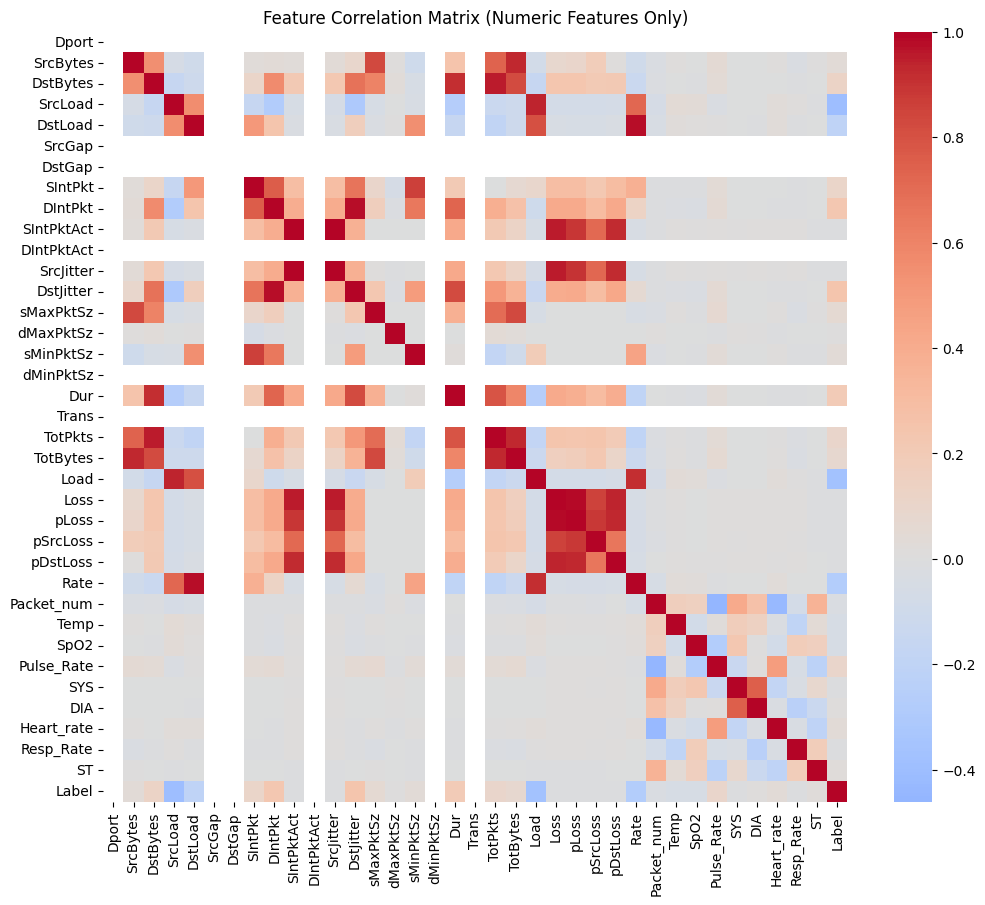

In [17]:
# ===========================================
# STEP 2: Basic Data Exploration
# ===========================================
print("Dataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())

print("\nClass Distribution:")
print(df['Label'].value_counts())

print("\nMissing Values:")
print(df.isnull().sum())

# ✅ Compute correlation only on numeric columns to avoid ValueError
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 10))
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix (Numeric Features Only)')
plt.show()


In [18]:
# ===========================================
# STEP 3: Preprocessing & Scaling
# ===========================================
y = df['Label']
X = df.drop(columns=['Label'])

# Encode categorical columns
cat_cols = ['Dir', 'Flgs', 'SrcAddr', 'DstAddr', 'Sport', 'SrcMac', 'DstMac']
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Scale numeric features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Encode target to ensure it's 0/1
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)


In [19]:
# ===========================================
# STEP 4: Function for Sequence Creation (Majority Vote Label)
# ===========================================
def create_sequences(X_data, y_data, seq_len):
    num_features = X_data.shape[1]
    num_sequences = len(X_data) // seq_len

    X_seq = X_data[:num_sequences * seq_len].reshape(num_sequences, seq_len, num_features)

    y_seq_majority = []
    for i in range(num_sequences):
        seq_labels = y_data[i*seq_len:(i+1)*seq_len]
        majority_label = np.bincount(seq_labels).argmax()
        y_seq_majority.append(majority_label)

    return X_seq, np.array(y_seq_majority)

In [20]:
# ===========================================
# STEP 5: Try Different Sequence Lengths & Pick One
# ===========================================
best_seq_len = 10  # default
best_val_auc = 0

for seq_len in [5, 10, 15, 20]:
    X_seq_tmp, y_seq_tmp = create_sequences(X_scaled, y_encoded, seq_len)

    # Temporal split (80% train, 20% test)
    split_point = int(0.8 * len(X_seq_tmp))
    y_seq_tmp = np.array(y_seq_tmp)
    X_train_tmp, X_test_tmp = X_seq_tmp[:split_point], X_seq_tmp[split_point:]
    y_train_tmp, y_test_tmp = y_seq_tmp[:split_point], y_seq_tmp[split_point:]

    # Quick model to test AUC
    model_tmp = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=(seq_len, X_scaled.shape[1])),
        MaxPooling1D(2),
        LSTM(16),
        Dense(1, activation='sigmoid')
    ])
    model_tmp.compile(optimizer='adam', loss='binary_crossentropy')
    model_tmp.fit(X_train_tmp, y_train_tmp, epochs=3, batch_size=64, verbose=0)

    y_val_probs = model_tmp.predict(X_test_tmp)
    auc_val = roc_auc_score(y_test_tmp, y_val_probs)
    print(f"Seq_len={seq_len}, Quick Val AUC={auc_val:.4f}")

    if auc_val > best_val_auc:
        best_val_auc = auc_val
        best_seq_len = seq_len

print(f"\n✅ Best sequence length selected: {best_seq_len} (AUC={best_val_auc:.4f})")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Seq_len=5, Quick Val AUC=0.9994


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Seq_len=10, Quick Val AUC=0.9997


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Seq_len=15, Quick Val AUC=0.9998


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Seq_len=20, Quick Val AUC=0.9769

✅ Best sequence length selected: 15 (AUC=0.9998)


In [21]:

# ===========================================
# STEP 6: Final Sequence Creation with best seq_len
# ===========================================
X_seq, y_seq_majority = create_sequences(X_scaled, y_encoded, best_seq_len)
split_point = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_point], X_seq[split_point:]
y_train, y_test = y_seq_majority[:split_point], y_seq_majority[split_point:]

num_features = X_scaled.shape[1]


In [22]:
# ===========================================
# STEP 7: Class Imbalance Handling
# ===========================================
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("\nClass Weights:", class_weight_dict)



Class Weights: {np.int64(0): np.float64(0.5702099737532809), np.int64(1): np.float64(4.0607476635514015)}


In [23]:
# ===========================================
# STEP 8: Build Improved CNN+LSTM Model
# ===========================================
model = Sequential()

# CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(best_seq_len, num_features)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# LSTM layer
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.4))

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 13, 64)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 13, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 4, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,937 (171.63 KB)

 Trainable params: 43,745 (170.88 KB)

 Non-trainable params: 192 (768.00 B)

In [24]:
# ===========================================
# STEP 9: Callbacks & Training
# ===========================================
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-6, monitor='val_loss')
]

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,  # Handle imbalanced classes
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7541 - loss: 0.6258 - val_accuracy: 0.9943 - val_loss: 0.6365 - learning_rate: 0.0010
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9568 - loss: 0.2341 - val_accuracy: 1.0000 - val_loss: 0.3353 - learning_rate: 0.0010
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9714 - loss: 0.0881 - val_accuracy: 0.9885 - val_loss: 0.1340 - learning_rate: 0.0010
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9717 - loss: 0.0479 - val_accuracy: 0.9540 - val_loss: 0.1040 - learning_rate: 0.0010
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9826 - loss: 0.0364 - val_accuracy: 0.9655 - val_loss: 0.0714 - learning_rate: 0.0010
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9855 - loss: 0.0359 - val_accuracy: 0.9080 - val_loss: 0.1700 - learning_rate: 0.0010
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9934 - loss: 0.0269 - val_acc

In [25]:

# ===========================================
# STEP 10: Model Evaluation & Threshold Optimization
# ===========================================
y_pred_probs = model.predict(X_test)

# Find optimal threshold using F1-score
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # avoid division by zero
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print(f"\n✅ Optimal threshold: {optimal_threshold:.4f}")

# Predictions with optimal threshold
y_pred_optimal = (y_pred_probs > optimal_threshold).astype(int)
y_pred_default = (y_pred_probs > 0.5).astype(int)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

✅ Optimal threshold: 0.3965


In [29]:
# ===========================================
# STEP 11: Performance Metrics
# ===========================================
print("\n" + "="*50)
print("PERFORMANCE WITH DEFAULT THRESHOLD (0.5):")
print("="*50)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_default))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_default))

print("\n" + "="*50)
print(f"PERFORMANCE WITH OPTIMAL THRESHOLD ({optimal_threshold:.4f}):")
print("="*50)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimal))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimal))

# AUC Score
auc = roc_auc_score(y_test, y_pred_probs)
print(f"\n AUC Score: {auc:.4f}")


PERFORMANCE WITH DEFAULT THRESHOLD (0.5):
Confusion Matrix:
[[191   0]
 [  1  26]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       191
           1       1.00      0.96      0.98        27

    accuracy                           1.00       218
   macro avg       1.00      0.98      0.99       218
weighted avg       1.00      1.00      1.00       218


PERFORMANCE WITH OPTIMAL THRESHOLD (0.3965):
Confusion Matrix:
[[191   0]
 [  1  26]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       191
           1       1.00      0.96      0.98        27

    accuracy                           1.00       218
   macro avg       1.00      0.98      0.99       218
weighted avg       1.00      1.00      1.00       218


 AUC Score: 1.0000


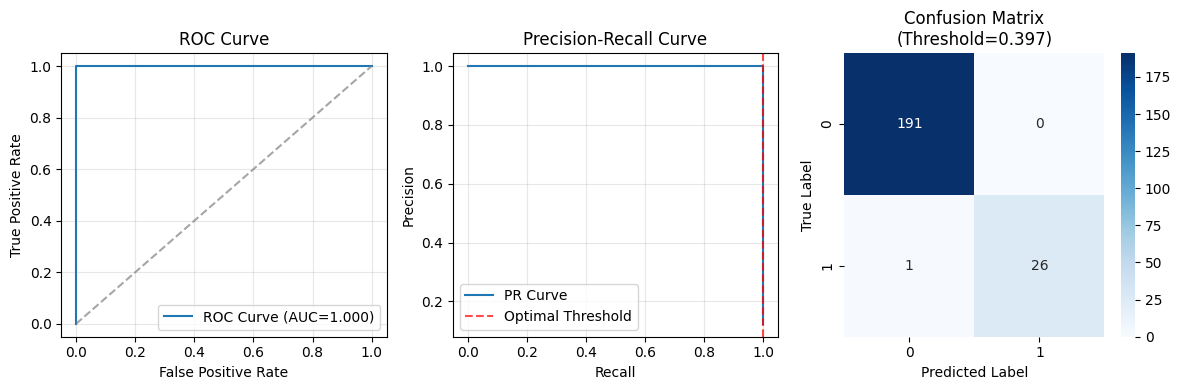

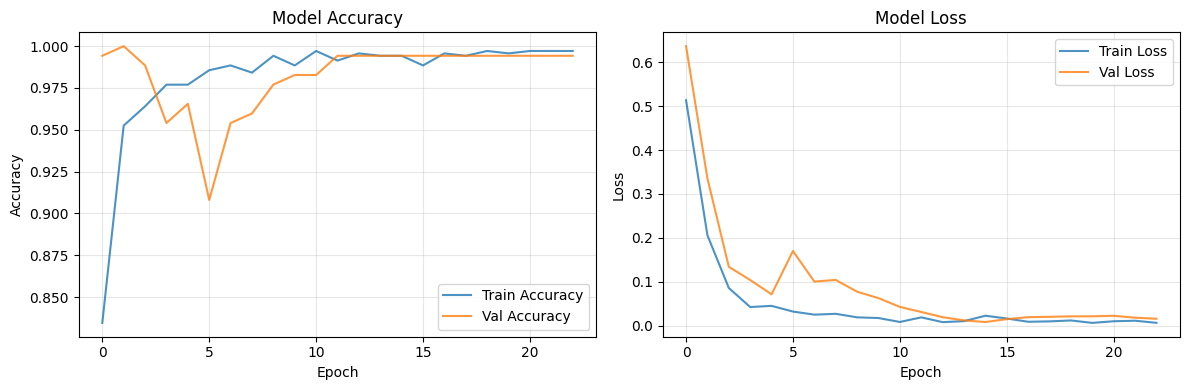

In [27]:

# ===========================================
# STEP 12: Visualizations
# ===========================================

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'--',color='gray', alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True, alpha=0.3)

# Precision-Recall Curve
plt.subplot(1, 3, 2)
plt.plot(recall, precision, label=f"PR Curve")
plt.axvline(x=recall[optimal_idx], color='red', linestyle='--', alpha=0.7, label=f'Optimal Threshold')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True, alpha=0.3)

# Confusion Matrix Heatmap
plt.subplot(1, 3, 3)
sns.heatmap(confusion_matrix(y_test, y_pred_optimal), annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix\n(Threshold={optimal_threshold:.3f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Training History
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', alpha=0.8)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', alpha=0.8)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', alpha=0.8)
plt.plot(history.history['val_loss'], label='Val Loss', alpha=0.8)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [28]:

# ===========================================
# STEP 13: Model Summary & Final Results
# ===========================================
print("\n" + "="*60)
print(" FINAL MODEL SUMMARY")
print("="*60)
print(f" Best Sequence Length: {best_seq_len}")
print(f" Optimal Threshold: {optimal_threshold:.4f}")
print(f" AUC Score: {auc:.4f}")
print(f" Training completed with early stopping")
print(f" Class imbalance handled with weights: {class_weight_dict}")
print("="*60)


 FINAL MODEL SUMMARY
 Best Sequence Length: 15
 Optimal Threshold: 0.3965
 AUC Score: 1.0000
 Training completed with early stopping
 Class imbalance handled with weights: {np.int64(0): np.float64(0.5702099737532809), np.int64(1): np.float64(4.0607476635514015)}


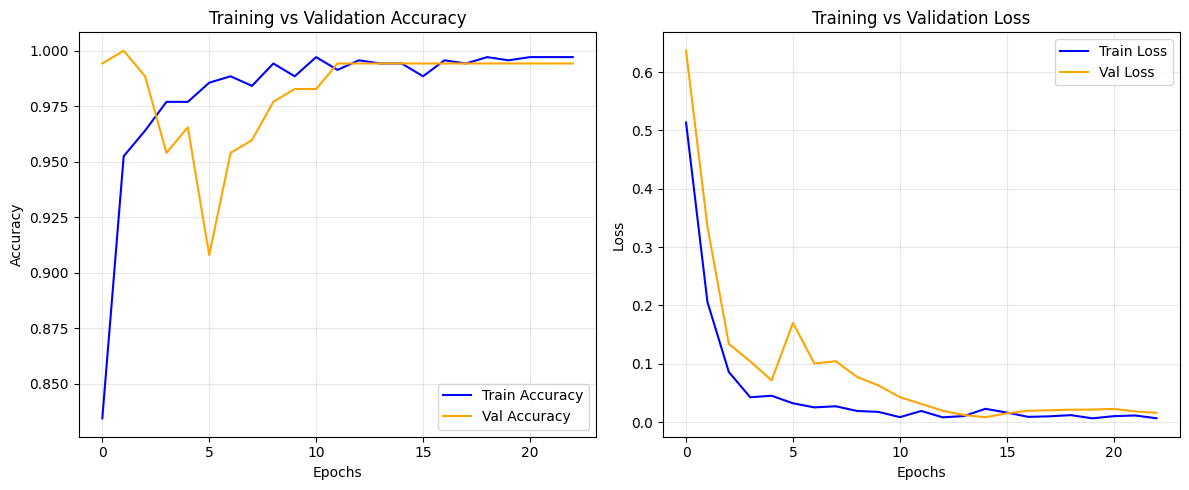

In [30]:
#  Plot training vs. validation curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
